In [5]:
# import vec2text
# corrector = vec2text.load_pretrained_corrector("text-embedding-ada-002")

# inversion_model = vec2text.models.InversionModel.from_pretrained("jxm/gtr__nq__32")
# corrector_model = vec2text.models.CorrectorEncoderModel.from_pretrained("jxm/gtr__nq__32__correct")


In [14]:

import vec2text
import torch
from transformers import AutoModel, AutoTokenizer, PreTrainedTokenizer, PreTrainedModel


def get_gtr_embeddings(text_list,
                       encoder: PreTrainedModel,
                       tokenizer: PreTrainedTokenizer) -> torch.Tensor:

    inputs = tokenizer(text_list,
                       return_tensors="pt",
                       max_length=128,
                       truncation=True,
                       padding="max_length",).to("cuda")

    with torch.no_grad():
        model_output = encoder(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
        hidden_state = model_output.last_hidden_state
        embeddings = vec2text.models.model_utils.mean_pool(hidden_state, inputs['attention_mask'])

    return embeddings


encoder = AutoModel.from_pretrained("sentence-transformers/gtr-t5-base").encoder.to("cuda")
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/gtr-t5-base")
corrector = vec2text.load_pretrained_corrector("gtr-base")

embeddings = get_gtr_embeddings([
       "Jack Morris is a PhD student at Cornell Tech in New York City",
       "It was the best of times, it was the worst of times, it was the age of wisdom, it was the age of foolishness, it was the epoch of belief, it was the epoch of incredulity",
       "You have to let it all go, Neo - fear, doubt, and disbelief. Free your mind!"
], encoder, tokenizer)

vec2text.invert_embeddings(
    embeddings=embeddings.cuda(),
    corrector=corrector,
    num_steps=20,
)

vec2text.invert_embeddings(
    embeddings=embeddings.mean(dim=0, keepdim=True).cuda(),
    corrector=corrector
)

import numpy as np

mixed_embeddings = []

for alpha in np.arange(0.0, 1.0, 0.1):
  mixed_embedding = torch.lerp(input=embeddings[0], end=embeddings[1], weight=alpha)
  text = vec2text.invert_embeddings(
      embeddings=mixed_embedding[None].cuda(),
      corrector=corrector,
      num_steps=20,
      sequence_beam_width=4,
  )[0]
  print(f'alpha={alpha:.1f}\t', text)
  mixed_embeddings.append(mixed_embedding)


for alpha in np.arange(0.0, 1.0, 0.1):
  mixed_embedding = torch.lerp(input=embeddings[1], end=embeddings[2], weight=alpha)
  text = vec2text.invert_embeddings(
      embeddings=mixed_embedding[None].cuda(),
      corrector=corrector,
      num_steps=20,
      sequence_beam_width=4,
  )[0]
  print(f'alpha={alpha:.1f}\t', text)
  mixed_embeddings.append(mixed_embedding)

Some weights of T5Model were not initialized from the model checkpoint at sentence-transformers/gtr-t5-base and are newly initialized: ['decoder.block.0.layer.0.SelfAttention.k.weight', 'decoder.block.0.layer.0.SelfAttention.o.weight', 'decoder.block.0.layer.0.SelfAttention.q.weight', 'decoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight', 'decoder.block.0.layer.0.SelfAttention.v.weight', 'decoder.block.0.layer.0.layer_norm.weight', 'decoder.block.0.layer.1.EncDecAttention.k.weight', 'decoder.block.0.layer.1.EncDecAttention.o.weight', 'decoder.block.0.layer.1.EncDecAttention.q.weight', 'decoder.block.0.layer.1.EncDecAttention.v.weight', 'decoder.block.0.layer.1.layer_norm.weight', 'decoder.block.0.layer.2.DenseReluDense.wi.weight', 'decoder.block.0.layer.2.DenseReluDense.wo.weight', 'decoder.block.0.layer.2.layer_norm.weight', 'decoder.block.1.layer.0.SelfAttention.k.weight', 'decoder.block.1.layer.0.SelfAttention.o.weight', 'decoder.block.1.layer.0.SelfAttention.q.weig

alpha=0.0	 Jack Morris is a PhD student at Morris Tech at Cornell in New York City
alpha=0.1	 Jack Morris is a PhD student at Joseph of Cornell Tech in New York City 
alpha=0.2	 Jack Morris     is a PhD student at Cornell Tech in the New York City
alpha=0.3	 Jack Morris is a PhD student at Jack Morris, the professor of Technology at Cornell in New York City
alpha=0.4	 Jack Morris is a PhD student at      at Cornell Tech in New York City and the Age of Either
alpha=0.5	 Jack Morris was a PhD student at Cornell, New York City. It is the epoch of wisdom, the epoch of best
alpha=0.6	 Jack Morris was a PhD student in Cornell, New York, it is the age of foolishness, it is the age of best epoch
alpha=0.7	 It was the age of jacks, it was the age of foolishness, it was the best time of Morris PhD at Cornell, New York
alpha=0.8	 It was the age of foolishness, it was the age of wisdom, it was the age of epoch, it was the best of place
alpha=0.9	 It was the age of foolishness, it was the age of be

In [6]:
# !uv pip install ipykernel


In [18]:
mixed_embeddings = np.array([
    x.cpu().numpy().T for x in mixed_embeddings
])

# mixed_embeddings = np.array(mixed_embeddings)

In [25]:
import umap

embedding = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='cosine').fit_transform(mixed_embeddings)

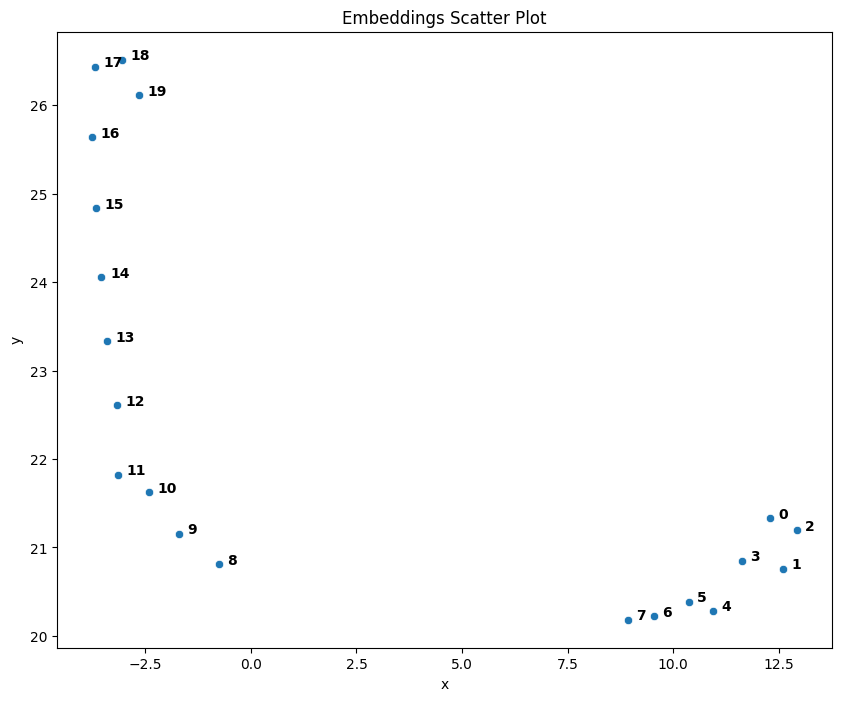

In [27]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Create a dataframe from the embeddings
df = pd.DataFrame(embedding, columns=['x', 'y'])

# Create a scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='x', y='y')

# Number each of the points in the scatterplot
for line in range(0, df.shape[0]):
     plt.text(df.x[line]+0.2, df.y[line], line, horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.title('Embeddings Scatter Plot')
plt.show()


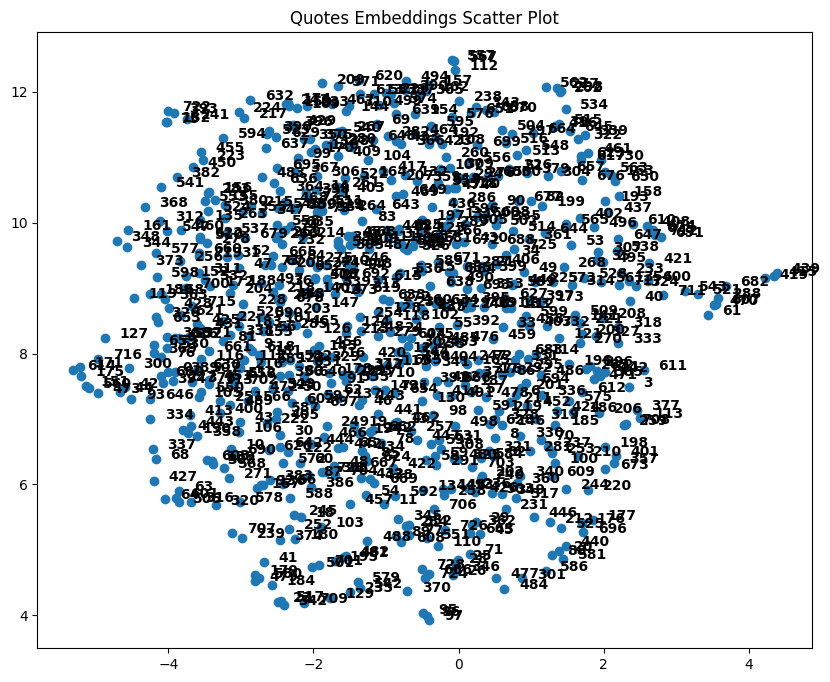

In [36]:
import pandas as pd
from matplotlib.widgets import Button

data = pd.read_csv("../movie_quotes.csv")

# Extract the quotes from the data
quotes = data['quote'].tolist()

# Use the T5 model to generate embeddings for the quotes
quote_embeddings = get_gtr_embeddings(quotes, encoder, tokenizer)

# Convert the embeddings to a numpy array
quote_embeddings = np.array([x.cpu().numpy().T for x in quote_embeddings])

# Use UMAP to reduce the dimensionality of the embeddings
quote_embedding = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='cosine').fit_transform(quote_embeddings)

# Create a dataframe from the embeddings
df_quotes = pd.DataFrame(quote_embedding, columns=['x', 'y'])


In [38]:
import pickle

# Save the UMAP model to a pickle file
with open('umap_model.pkl', 'wb') as file:
    pickle.dump(quote_embedding, file)


In [ ]:
se

In [60]:
df_quotes.reset_index()

index         x          y
0        0 -4.005555   7.718529
1        1 -1.464082  11.154277
2        2 -0.861912   9.176706
3        3  2.346378   7.492670
4        4 -3.799121   6.828167
..     ...       ...        ...
727    727 -0.513913   8.683650
728    728 -0.502705   4.707011
729    729 -0.166365   8.709207
730    730  1.964358  10.960879
731    731 -1.010313   7.443371

[732 rows x 3 columns]

In [62]:
# # Create a scatter plot
# fig, ax = plt.subplots(figsize=(20, 20))
# scatter = ax.scatter(df_quotes['x'], df_quotes['y'])

# selected_points = []

# def on_pick(event):
#     ind = event.ind
#     selected_points.append(df_quotes.iloc[ind])

# fig.canvas.mpl_connect('pick_event', on_pick)

# # Number each of the points in the scatterplot
# for line in range(0, df_quotes.shape[0]):
#      plt.text(df_quotes.x[line]+0.2, df_quotes.y[line], line, horizontalalignment='left', size='medium', color='black', weight='semibold')

# plt.title('Quotes Embeddings Scatter Plot')

# # Save the figure
# plt.savefig('quotes_embeddings_scatter_plot.png')

# Create the same plot in Altair
import altair as alt

# Create a dataframe for the text labels
df_labels = pd.DataFrame({'x': df_quotes['x'] + 0.2, 'y': df_quotes['y'], 'text': range(0, df_quotes.shape[0])})

# Create the scatter plot with interactive color change on click
scatter_plot = alt.Chart(df_quotes.reset_index()).mark_circle(size=60).encode(
    x='x',
    y='y',
    tooltip=['x', 'y','index'],
    color=alt.condition(alt.datum.index == alt.value(0), alt.value('red'), alt.value('blue'))
).properties(
    width=800,
    height=800
).interactive()

# # Add the text labels
# text_plot = alt.Chart(df_labels).mark_text(
#     align='left',
#     baseline='middle',
#     size=11
# ).encode(
#     x='x',
#     y='y',
#     text='text'
# )

# Combine the scatter plot and the text labels
# altair_plot = scatter_plot + text_plot

# Display the plot
# altair_plot.save('quotes_embeddings_scatter_plot_altair.html')

scatter_plot

alt.Chart(...)

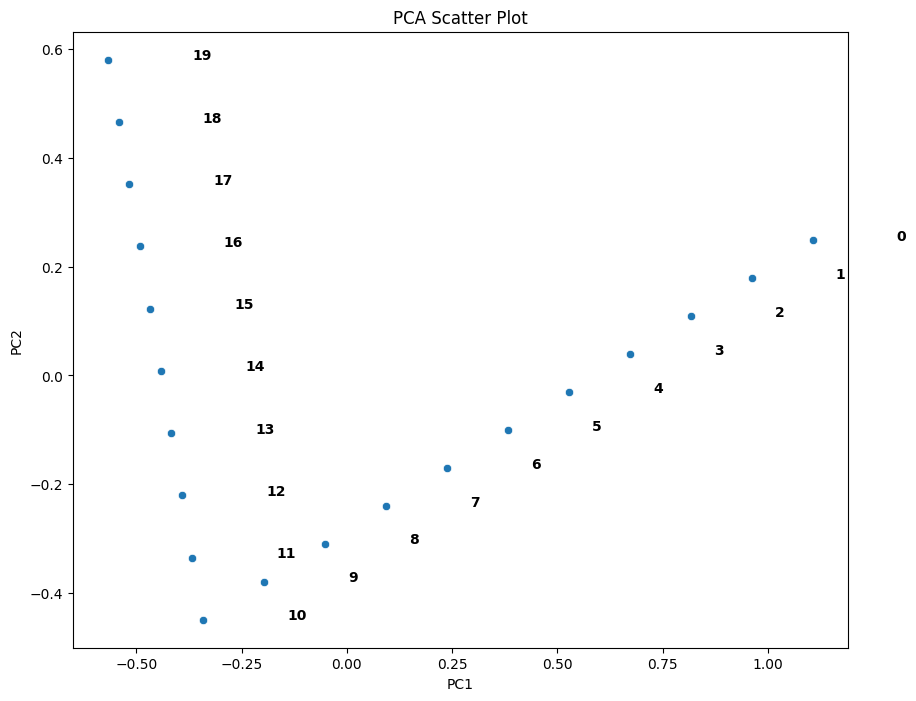

In [29]:
from sklearn.decomposition import PCA

# Apply PCA to the embeddings
pca = PCA(n_components=2)
pca_result = pca.fit_transform(mixed_embeddings)

# Create a dataframe from the PCA results
df_pca = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])

# Create a scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_pca, x='PC1', y='PC2')

# Number each of the points in the scatterplot
for line in range(0, df_pca.shape[0]):
     plt.text(df_pca.PC1[line]+0.2, df_pca.PC2[line], line, horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.title('PCA Scatter Plot')
plt.show()


In [63]:
selected_indices = [124, 714, 652, 232, 635, 403, 469, 197, 436, 500, 677, 644, 225, 33, 165, 391, 115]

In [64]:
df_quotes

x          y
0   -4.005555   7.718529
1   -1.464082  11.154277
2   -0.861912   9.176706
3    2.346378   7.492670
4   -3.799121   6.828167
..        ...        ...
727 -0.513913   8.683650
728 -0.502705   4.707011
729 -0.166365   8.709207
730  1.964358  10.960879
731 -1.010313   7.443371

[732 rows x 2 columns]

<Axes: xlabel='x', ylabel='y'>

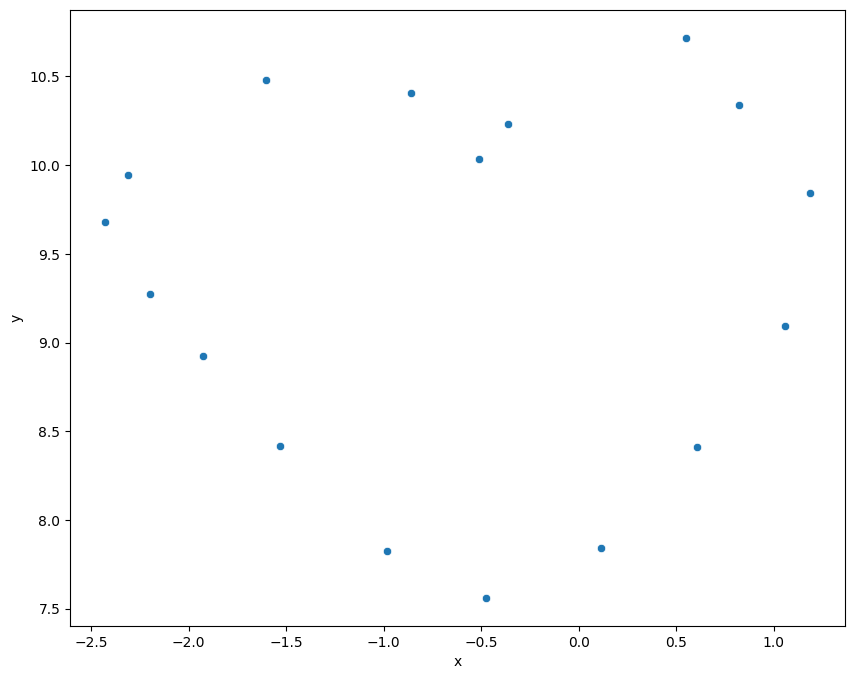

In [65]:
# Filter the dataframe to only include the selected indices
df_selected = df_quotes.loc[selected_indices]

# Create a scatter plot for the selected indices
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_selected, x='x', y='y')

# # Number each of the points in the scatterplot
# for line in range(0, df_selected.shape[0]):
#      plt.text(df_selected.PC1.iloc[line]+0.2, df_selected.PC2.iloc[line], df_selected.index[line], horizontalalignment='left', size='medium', color='black', weight='semibold')

# plt.title('PCA Scatter Plot for Selected Indices')
# plt.show()


In [68]:
df_quotes.shape

(732, 2)

In [67]:
quote_embeddings.shape

(732, 768)

In [69]:
landmarks = quote_embeddings[selected_indices]

In [74]:
mixed_embeddings_landmarks = []
for i in range(len(landmarks)-1):
    start = landmarks[i]
    end = landmarks[i+1]

    for alpha in np.arange(0.0, 1.0, 0.1):
        mixed_embedding = torch.lerp(input=torch.tensor(start).to('cuda'), end=torch.tensor(end).to('cuda'), weight=alpha)
        text = vec2text.invert_embeddings(
            embeddings=mixed_embedding[None].cuda(),
            corrector=corrector,
            num_steps=20,
            sequence_beam_width=4,
        )[0]
        print(f'alpha={alpha:.1f}\t', text)
        mixed_embeddings_landmarks.append(mixed_embedding)

alpha=0.0	 Why don't you make like a tree and get out of here.        
alpha=0.1	 Why don't you make like a tree and get out of here.        
alpha=0.2	 If you don't get out here, make like a tree       .
alpha=0.3	 If you get out of here, why don't you make like a tree and get what you deserve.    
alpha=0.4	 If you don't like what you do, get out from a tree and make a f*ck! You get what you deserve.
alpha=0.5	 You get what you deserve!          Make you like a tree!
alpha=0.6	 You get what you deserve!            Fuck-
alpha=0.7	 You get what you deserve           f*cking!
alpha=0.8	 You get what you deserve!            Fuck-
alpha=0.9	 You get what you deserve!           F*cking!
alpha=0.0	 You get what you deserve!            fuck
alpha=0.1	 You get what you deserve!           f***ing!
alpha=0.2	 You get what you deserve!           f***ing!
alpha=0.3	 You get what you deserve!            fuck
alpha=0.4	 You get what you deserve           ! 
alpha=0.5	 If you do what you love and d

In [76]:
mixed_embeddings_landmarks_cpu = np.array([x.cpu().numpy().T for x in mixed_embeddings_landmarks])

In [85]:
len(mixed_embeddings_landmarks_cpu)

160

In [102]:
# load the umap model from pickle

import pickle

with open('umap_model.pkl', 'rb') as file:
    umap = pickle.load(file)


In [103]:
# embeds = umap.UMAP(n_neighbors=160, min_dist=0, metric='cosine', ).fit_transform(mixed_embeddings_landmarks_cpu)

embeds = umap.transform(mixed_embeddings_landmarks_cpu)

# Create a DataFrame from the embeddings
df_embeds = pd.DataFrame(embeds, columns=['x', 'y'])

# Plot the embeddings
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(data=df_embeds, x='x', y='y')
plt.title('UMAP Scatter Plot for Mixed Embeddings')

# Adding text labels to the scatter plot
for line in range(0, df_embeds.shape[0]):
     scatter.text(df_embeds.x[line]+0.2, df_embeds.y[line], 
     df_embeds.index[line], horizontalalignment='left', 
     size='medium', color='black', weight='semibold')

plt.show()




AttributeError: 'numpy.ndarray' object has no attribute 'transform'

In [ ]:
embeds = umap.UMAP(n_neighbors=160, min_dist=0, metric='cosine', ).fit_transform(mixed_embeddings_landmarks_cpu)

# Create a DataFrame from the embeddings
df_embeds = pd.DataFrame(embeds, columns=['x', 'y'])

# Plot the embeddings
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_embeds, x='x', y='y')
plt.title('UMAP Scatter Plot for Mixed Embeddings')
plt.show()

In [159]:
import pandas as pd
from matplotlib.widgets import Button
from umap import UMAP

data = pd.read_csv("../movie_quotes.csv")

# Extract the quotes from the data
quotes = data['quote'].tolist()

# Use the T5 model to generate embeddings for the quotes
quote_embeddings = get_gtr_embeddings(quotes, encoder, tokenizer)

# Convert the embeddings to a numpy array
quote_embeddings = np.array([x.cpu().numpy().T for x in quote_embeddings])

# Use UMAP to reduce the dimensionality of the embeddings
umap = UMAP(n_neighbors=5, min_dist=0.3, metric='cosine', random_state=42).fit(quote_embeddings)
quote_embedding = umap.transform(quote_embeddings)

# Create a dataframe from the embeddings
df_quotes = pd.DataFrame(quote_embedding, columns=['x', 'y'])

/home/gabe/prompt-skywriting/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [160]:
import pandas as pd

heart = pd.read_csv("../heart.csv",header=None)
heart.columns =['x','y']

In [161]:
from sklearn.preprocessing import MinMaxScaler

In [162]:
mms = MinMaxScaler(feature_range=(0.2,0.7))
scaled_heart = mms.fit_transform(heart)

In [163]:
mms2 = MinMaxScaler()
quote_embeddings_scaled = mms2.fit_transform(quote_embedding)

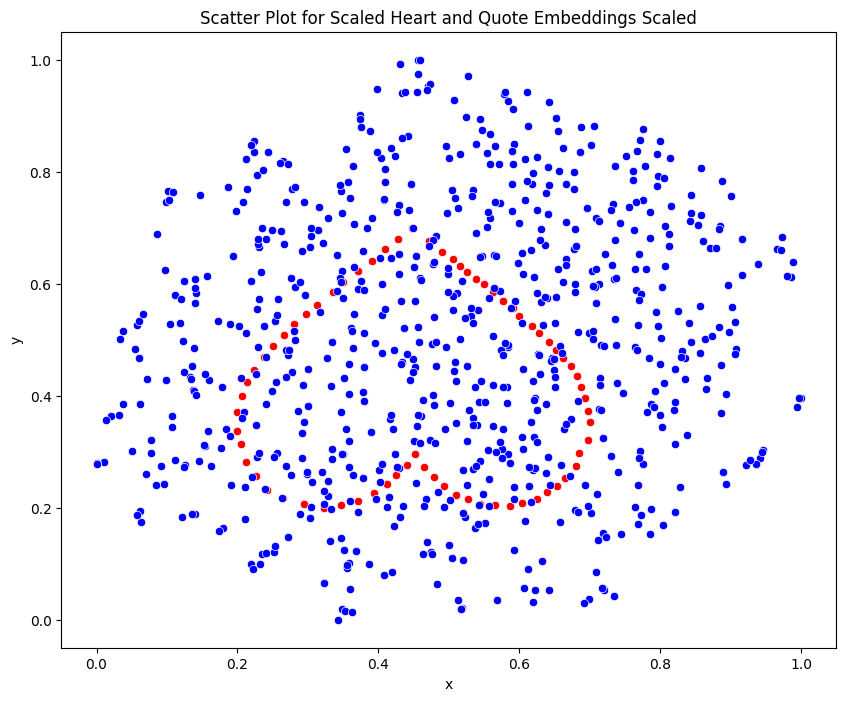

In [164]:
# Create a DataFrame from the scaled heart data
df_scaled_heart = pd.DataFrame(scaled_heart, columns=['x', 'y'])

# Create a DataFrame from the quote embeddings scaled data
df_quote_embeddings_scaled = pd.DataFrame(quote_embeddings_scaled, columns=['x', 'y'])

# Plot the scaled heart data
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_scaled_heart, x='x', y='y', color='red')

# Overlay the quote embeddings scaled data
sns.scatterplot(data=df_quote_embeddings_scaled, x='x', y='y', color='blue')

plt.title('Scatter Plot for Scaled Heart and Quote Embeddings Scaled')
plt.show()


In [165]:
from scipy.spatial import distance_matrix

# Compute pairwise distances
distances = distance_matrix(df_scaled_heart.values, df_quote_embeddings_scaled.values)

# Convert to DataFrame
# df_distances = pd.DataFrame(distances, columns=df_quote_embeddings_scaled.index, index=df_scaled_heart.index)


In [166]:
print(distances.shape)

(70, 732)


In [167]:
nearest_points = np.unique(distances.argmin(axis=1))

In [168]:
nearest_points

array([  2,  11,  13,  43,  57,  58,  93, 102, 106, 115, 128, 143, 149,
       168, 181, 182, 222, 252, 256, 257, 308, 312, 368, 391, 394, 414,
       431, 453, 457, 459, 462, 478, 497, 510, 524, 526, 532, 544, 547,
       588, 592, 596, 598, 602, 633, 644, 654, 667, 688, 698, 702])

In [169]:
embedding_landmarks = quote_embeddings[nearest_points]

In [170]:
embedding_landmarks.shape

(51, 768)

In [173]:
mixed_embeddings_landmarks = []
for i in range(len(embedding_landmarks)):
    try:
        start = embedding_landmarks[i]
        end = embedding_landmarks[i+1]
    except IndexError:
        start = embedding_landmarks[-1]
        end = embedding_landmarks[0]

    for alpha in np.arange(0.0, 1.0, 0.1):
        mixed_embedding = torch.lerp(input=torch.tensor(start).to('cuda'), end=torch.tensor(end).to('cuda'), weight=alpha)
        text = vec2text.invert_embeddings(
            embeddings=mixed_embedding[None].cuda(),
            corrector=corrector,
            num_steps=20,
            sequence_beam_width=4,
        )[0]
        print(f'alpha={alpha:.1f}\t', text)
        mixed_embeddings_landmarks.append(mixed_embedding)

alpha=0.0	 It's alive! It's alive!           
alpha=0.1	 It's alive!           It's alive! 
alpha=0.2	 It's alive!           It's alive! 
alpha=0.3	 It's alive!           It's alive! 
alpha=0.4	 It's alive! It's alive!           
alpha=0.5	 It's alive, I will never be the witness of hunger again!        
alpha=0.6	 As a witness, It's alive, It's alive, God! Never be hungry again.
alpha=0.7	       As I'm the witness, God's alive, it's never hungry again!
alpha=0.8	    As God's witness, I'm never hungry again.      
alpha=0.9	 As God is my witness,         I'll never be hungry again. 
alpha=0.0	        As God is my witness, I'll never be hungry again.
alpha=0.1	 As God is my witness, I'll never be hungry again.         
alpha=0.2	 As God's witness,         I'll never be hungry, again.
alpha=0.3	 Here's God, as witness.        I'm never hungry again at you.
alpha=0.4	 Here's what I'm looking at you, God, You're never hungry again, kid. 
alpha=0.5	            Here's looking at you, kid.
al

In [174]:
mixed_embeddings_landmarks

[tensor([-1.3948e-01, -2.2180e-02,  7.7844e-03,  1.3787e-01, -2.4724e-02,
         -7.3532e-02,  9.7116e-03, -5.8673e-02, -3.5626e-02,  3.4723e-02,
         -3.6797e-02,  2.5984e-02, -1.9299e-02,  9.3996e-02, -2.6797e-02,
          4.2759e-02,  1.2044e-02, -7.1523e-02,  2.0286e-03, -1.0571e-01,
         -1.2526e-01, -8.6683e-02,  1.0312e-02, -1.5832e-01,  5.9884e-02,
         -3.1634e-03,  3.6518e-02, -9.3237e-02, -1.1982e-02, -3.8288e-02,
          2.7822e-02, -7.0279e-02,  3.3531e-02, -1.8604e-01,  7.0595e-02,
         -4.6737e-02, -3.9203e-02,  6.4030e-02, -3.6859e-02,  6.6770e-03,
         -4.1011e-02, -1.5782e-02,  2.7832e-02, -1.6455e-02, -1.9401e-02,
          2.2617e-02, -2.5879e-02,  1.2594e-01, -8.6545e-02,  9.8976e-03,
         -2.9014e-02, -1.5692e-02, -2.9292e-02, -8.6571e-02, -1.0784e-02,
          7.1965e-02,  1.9452e-02, -8.6636e-02, -5.3392e-02,  1.0447e-02,
          6.2875e-02, -2.9431e-01, -4.0045e-02,  2.5795e-02, -6.5290e-02,
         -6.0842e-02,  1.5823e-02,  2.

In [175]:
mixed_embeddings_landmarks_cpu = np.array([x.cpu().numpy().T for x in mixed_embeddings_landmarks])

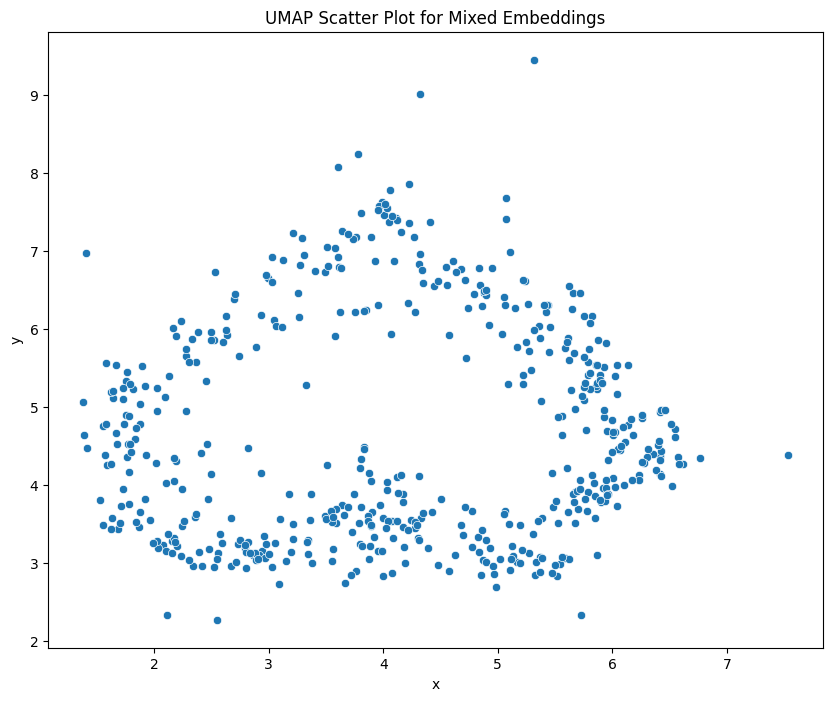

In [177]:
embeds = umap.transform(mixed_embeddings_landmarks_cpu)

# Create a DataFrame from the embeddings
df_embeds = pd.DataFrame(embeds, columns=['x', 'y'])

# Plot the embeddings
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(data=df_embeds, x='x', y='y')
plt.title('UMAP Scatter Plot for Mixed Embeddings')

# # Adding text labels to the scatter plot
# for line in range(0, df_embeds.shape[0]):
#      scatter.text(df_embeds.x[line]+0.2, df_embeds.y[line], 
#      df_embeds.index[line], horizontalalignment='left', 
#      size='medium', color='black', weight='semibold')

plt.show()

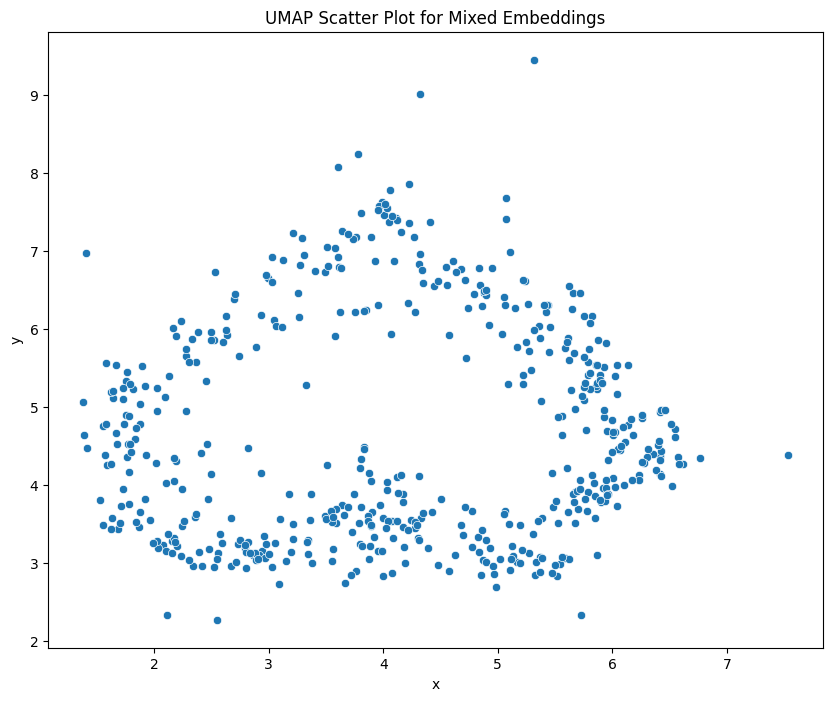

In [179]:
new_embeds = UMAP(n_neighbors=160, min_dist=0, metric='cosine', ).fit_transform(mixed_embeddings_landmarks_cpu)
# Create a DataFrame from the embeddings
df_embeds = pd.DataFrame(embeds, columns=['x', 'y'])

# Plot the embeddings
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(data=df_embeds, x='x', y='y')
plt.title('UMAP Scatter Plot for Mixed Embeddings')

# # Adding text labels to the scatter plot
# for line in range(0, df_embeds.shape[0]):
#      scatter.text(df_embeds.x[line]+0.2, df_embeds.y[line], 
#      df_embeds.index[line], horizontalalignment='left', 
#      size='medium', color='black', weight='semibold')

plt.show()

In [180]:
new_embeds

array([[1.6997272, 9.456696 ],
       [1.7294368, 9.487504 ],
       [1.6813122, 9.459523 ],
       ...,
       [1.7107714, 9.434044 ],
       [1.7102746, 9.448512 ],
       [1.7137353, 9.455957 ]], dtype=float32)

<Axes: xlabel='x', ylabel='y'>

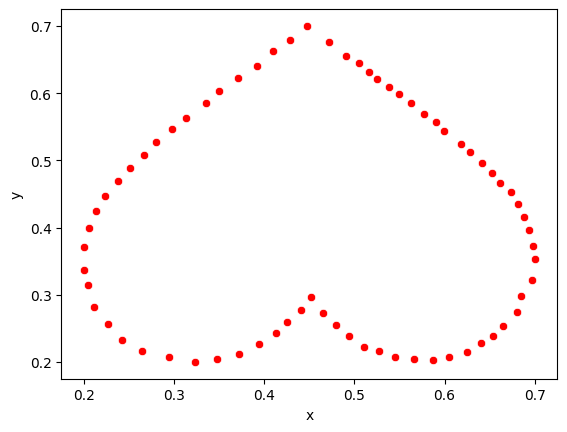

In [184]:
sns.scatterplot(data=df_scaled_heart, x='x', y='y', color='red')